In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

## ActiveLearningPipeline Class

In [2]:
class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 nodes_df_path,
                 subject_mapping_path):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.nodes_df_path = nodes_df_path
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        self.nodes_df = pd.read_csv(nodes_df_path)
        self.feature_vectors = self._read_feature_vectors()
        self.labels = self._read_labels(subject_mapping_path)

        # Map the node IDs to their indices in the feature vectors
        self._map_node_id_to_index()

        # Initiate the model to be used in the active learning pipeline
        self._initiate_model()

    def _read_feature_vectors(self):
        """
        Read feature vectors from the nodes dataframe
        :return:
        feature_vectors: numpy array, feature vectors
        """
        feature_vectors_raw = self.nodes_df['features'].apply((lambda x: x.strip('][').split(', ')))
        return np.array([[float(val) for val in feature_vector] for feature_vector in feature_vectors_raw])

    def _read_labels(self, subject_mapping_path):
        """
        Read subjects from the nodes dataframe, and convert them to labels (integers)
        :return:
        labels: numpy array, labels
        """
        with open(subject_mapping_path, 'rb') as f:
            subject_mapping = pickle.load(f)
        labels = self.nodes_df['subject'].apply(lambda x: subject_mapping[x])
        return np.array(labels)
    
    def _evaluate_model(self, trained_model):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        preds = trained_model.predict(self.feature_vectors[self.test_indices])
        return round(np.mean(preds == self.labels[self.test_indices]), 3)
    
    def _initiate_model(self):
        """
        Initiate the model to be used in the active learning pipeline
        """
        if self.model == 'RandomForest':
            self.model = RandomForestClassifier()
        elif self.model == 'SVM':
            self.model = SVC()
        else:
            self.model = LogisticRegression()

    def _map_node_id_to_index(self):
        """
        Create a dictionary to map the node IDs to their indices in the feature vectors
        """
        index_dict = {id: i for i, id in enumerate(self.nodes_df['nodeId'])}
        self.train_indices = np.array([index_dict[id] for id in self.train_indices])
        self.test_indices = np.array([index_dict[id] for id in self.test_indices])
        self.available_pool_indices = np.array([index_dict[id] for id in self.available_pool_indices])

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """

        accuracy_scores = []

        for iteration in range(self.iterations):
            if len(self.train_indices) > 600:
                # raise error if the train set is larger than 600 samples:
                raise ValueError('The train set is larger than 600 samples')
            
            # train the model
            self.model.fit(self.feature_vectors[self.train_indices], self.labels[self.train_indices])

            # select the samples to be added to the train set
            selected_sample_idx = self._get_samples()

            # add the selected sample to the train set
            self.train_indices = np.append(self.train_indices, selected_sample_idx)

            # remove the selected sample from the available pool
            indices_to_delete = np.where(np.isin(self.available_pool_indices,   selected_sample_idx))[0]
            self.available_pool_indices = np.delete(self.available_pool_indices, indices_to_delete)

            # TODO: Do not change the lines that are already implemented here in this method. Only add your code before and after them.
            accuracy = self._evaluate_model(self.model)
            accuracy_scores.append(accuracy)

        return accuracy_scores
    
    def _get_samples(self):
        """
        Get the samples to be added to the train set based on the selection criterion
        :return:
        selected_samples: list, indices of the selected samples
        """
        if self.selection_criterion == 'random':
            return self._random_sampling()
        elif self.selection_criterion == 'uncertainty':
            return self._uncertainty_sampling()
        else:
            return self._custom_sampling()
        
    def _random_sampling(self):
        """
        Randomly select samples from the available pool
        :return:
        selected_samples: list, indices of the selected samples
        """
        return np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
    
    def _uncertainty_sampling(self):
        """
        Select samples based on the uncertainty of the model predictions. In this case, samples with the highest entropy
        :return:
        selected_samples: list, indices of the selected samples
        """
        # Get the predictions of the model for the available pool samples
        predictions = self.model.predict_proba(self.feature_vectors
                                                      [self.available_pool_indices])
        # Calculate the entropy of the predictions
        uncertainty_scores = np.array([entropy(prediction) for prediction in predictions])
        # Select the samples with the highest entropy
        indices = np.argsort(uncertainty_scores)[-self.budget_per_iter:]        
        return self.available_pool_indices[indices]
    
    def _custom_sampling(self):
        """
        Select samples based on a custom criterion. In this case, samples with the lowest density
        :return:
        selected_samples: list, indices of the selected samples
        """
        # Calculate the density of the samples
        distances = euclidean_distances(self.feature_vectors[self.available_pool_indices], 
                                        self.feature_vectors[self.train_indices])
        density_scores = np.sum(distances, axis=1)
        # Select the samples with the lowest density
        selected_indices = np.argsort(density_scores)[:self.budget_per_iter]
        return selected_indices
    


In [3]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [4]:
model = 'RandomForestClassifier' # Choose a model ('RandomForestClassifier', 'SVC', 'LogisticRegression')
with open('data/indices_dict_part1.pkl', 'rb') as f:
    indices_dict = pickle.load(f)
available_pool_indices = indices_dict['available_pool_indices']
train_indices = indices_dict['train_indices']
test_indices = indices_dict['test_indices']
iterations = 30
budget_per_iter = 19
nodes_df_path = 'data/nodes.csv'
subject_mapping_path = 'data/subject_mapping.pkl'

selection_criteria = ['uncertainty','random','custom'] # Add more criteria if needed
accuracy_scores_dict = defaultdict(list)

Criterion: uncertainty


100%|██████████| 30/30 [00:03<00:00,  7.57it/s]


final accuracy:  0.718
Criterion: random


100%|██████████| 30/30 [00:02<00:00, 10.82it/s]


final accuracy:  0.671
Criterion: custom


100%|██████████| 30/30 [00:04<00:00,  7.39it/s]


final accuracy:  0.746


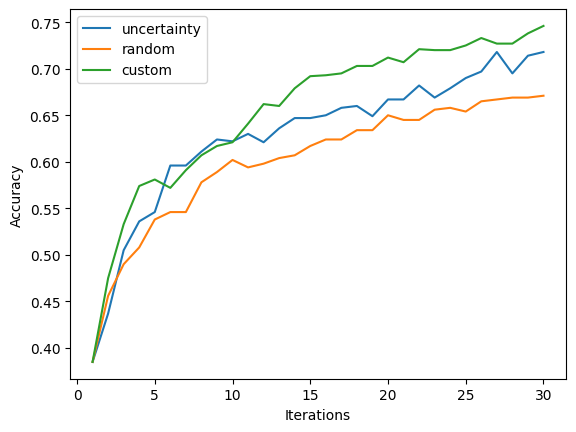

In [5]:
model = 'SVC'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

Criterion: uncertainty


100%|██████████| 30/30 [00:04<00:00,  7.07it/s]


final accuracy:  0.718
Criterion: random


100%|██████████| 30/30 [00:02<00:00, 10.75it/s]


final accuracy:  0.662
Criterion: custom


100%|██████████| 30/30 [00:04<00:00,  7.42it/s]

final accuracy:  0.746


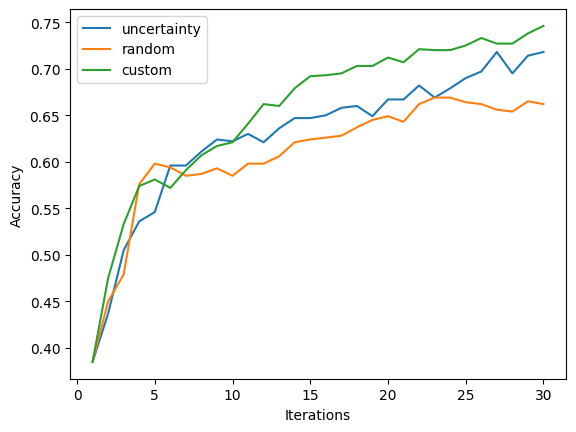

In [6]:
model = 'RandomForestClassifier'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

Criterion: uncertainty


100%|██████████| 30/30 [00:04<00:00,  7.22it/s]


final accuracy:  0.718
Criterion: random


100%|██████████| 30/30 [00:02<00:00, 11.84it/s]


final accuracy:  0.686
Criterion: custom


100%|██████████| 30/30 [00:04<00:00,  7.48it/s]


final accuracy:  0.746


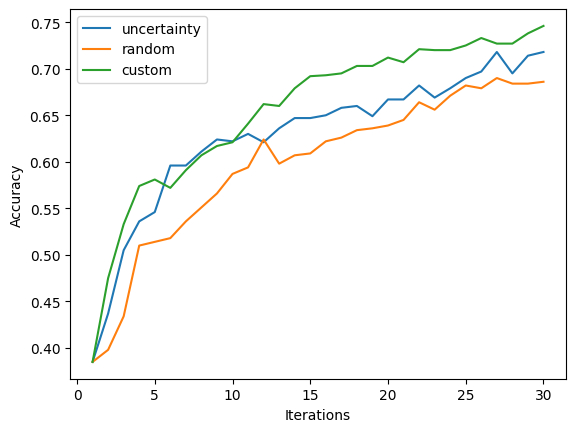

In [7]:
model = 'LogisticRegression'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

## Compare Parameters

In [8]:
models = ['SVC', 'RandomForestClassifier', 'LogisticRegression']
experiments_tuples = [(19,30),(39,15),(59,10)] #(budget, iterations)

def explore_selection_criteria(criterion):
    experiment_dict = {}

    for model in models:
        print(f'### Model: {model} ###')

        for i, (budget, iterations) in enumerate(experiments_tuples):
            print(f'Budget: {budget}, Iterations: {iterations}')
            
            AL_class = ActiveLearningPipeline(model=model,
                                              test_indices=test_indices,
                                              available_pool_indices=available_pool_indices,
                                              train_indices=train_indices,
                                              selection_criterion=criterion,
                                              iterations=iterations,
                                              budget_per_iter=budget,
                                              nodes_df_path=nodes_df_path,
                                              subject_mapping_path=subject_mapping_path)
            experiment_dict[(model, i)] = AL_class.run_pipeline()
            print("final accuracy: ", experiment_dict[(model, i)][-1])

    return experiment_dict

In [9]:
### Random sampling:
random_dict = explore_selection_criteria('random')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:02<00:00, 12.28it/s]


final accuracy:  0.69
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


final accuracy:  0.68
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  8.01it/s]


final accuracy:  0.686
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:03<00:00,  9.49it/s]


final accuracy:  0.688
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00, 11.43it/s]


final accuracy:  0.69
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:00<00:00, 10.22it/s]


final accuracy:  0.68
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:02<00:00, 11.40it/s]


final accuracy:  0.701
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00, 11.97it/s]


final accuracy:  0.707
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:00<00:00, 10.71it/s]

final accuracy:  0.677


In [10]:
### Uncertainty sampling:
uncertainty_dict = explore_selection_criteria('uncertainty')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:03<00:00,  7.59it/s]


final accuracy:  0.718
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00,  8.20it/s]


final accuracy:  0.705
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


final accuracy:  0.699
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:04<00:00,  6.21it/s]


final accuracy:  0.718
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:02<00:00,  7.04it/s]


final accuracy:  0.705
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


final accuracy:  0.699
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:04<00:00,  7.39it/s]


final accuracy:  0.718
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00,  7.57it/s]


final accuracy:  0.705
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  6.41it/s]

final accuracy:  0.699


In [11]:
### Custom sampling:
custom_dict = explore_selection_criteria('custom')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:04<00:00,  6.99it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:02<00:00,  7.23it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


final accuracy:  0.733
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:03<00:00,  7.61it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00,  7.68it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  7.54it/s]


final accuracy:  0.733
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:03<00:00,  7.87it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:01<00:00,  7.81it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


final accuracy:  0.733


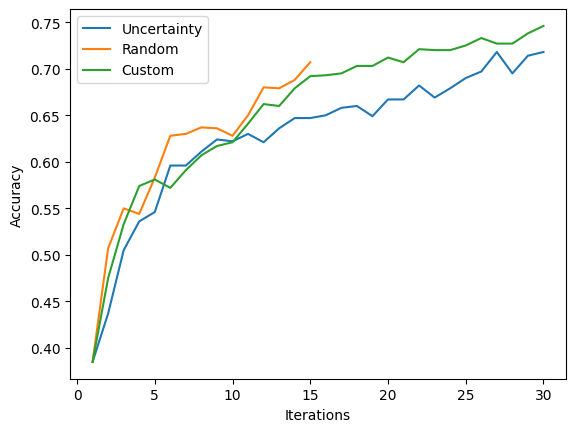

In [20]:
### plot only best logistic regression models:

rand_reg = random_dict[('LogisticRegression', 1)]
uncertainty_reg = uncertainty_dict[('LogisticRegression', 0)]
custom_reg = custom_dict[('LogisticRegression', 0)]

plt.plot(range(1, len(uncertainty_reg) + 1), uncertainty_reg, label='Uncertainty')
plt.plot(range(1, len(rand_reg) + 1), rand_reg, label='Random')
plt.plot(range(1, len(custom_reg) + 1), custom_reg, label='Custom')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()